# Job recommendation engine


* Which country, state and city are popular among job creator?
* Which country, state and city are popular among job seekers?
* Recommend similar jobs based on the jobs title, description
* Recommend jobs based on similar user profiles

## Import dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
# from nltk.stem.snowball import SnowballStemmer
# from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.corpus import wordnet
# from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense


2023-09-18 10:14:06.071702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 10:14:07.224820: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11/lib64:/usr/local/cuda-11.4/lib64
2023-09-18 10:14:07.224890: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11/lib64:/usr/loca

## Load dataset

In [2]:
!ls ./input_data/*.tsv

ls: cannot access './input_data/*.tsv': No such file or directory


In [77]:
apps = pd.read_csv('/home/nadiera/Job_RecSys/Job_recommendation_engine/job-recommendation/apps.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)
user_history = pd.read_csv('/home/nadiera/Job_RecSys/Job_recommendation_engine/job-recommendation/user_history.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)
jobs = pd.read_csv('/home/nadiera/Job_RecSys/Job_recommendation_engine/job-recommendation/jobs.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)
users = pd.read_csv('/home/nadiera/Job_RecSys/Job_recommendation_engine/job-recommendation/users.tsv' ,delimiter='\t',encoding='utf-8', error_bad_lines=False)
test_users = pd.read_csv('/home/nadiera/Job_RecSys/Job_recommendation_engine/job-recommendation/test_users.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)

b'Skipping line 122433: expected 11 fields, saw 12\n'
b'Skipping line 602576: expected 11 fields, saw 12\n'
b'Skipping line 990950: expected 11 fields, saw 12\n'


In [78]:
apps.dropna(inplace=True)
apps.head()

UserID  WindowID  Split          ApplicationDate   JobID
0      47         1  Train  2012-04-04 15:56:23.537  169528
1      47         1  Train  2012-04-06 01:03:00.003  284009
2      47         1  Train  2012-04-05 02:40:27.753    2121
3      47         1  Train  2012-04-05 02:37:02.673  848187
4      47         1  Train  2012-04-05 22:44:06.653  733748

In [79]:
user_history.dropna(inplace=True)
user_history.head()

UserID  WindowID  Split  Sequence  \
0      47         1  Train         1   
1      47         1  Train         2   
2      47         1  Train         3   
3      72         1  Train         1   
4      72         1  Train         2   

                                            JobTitle  
0  National Space Communication Programs-Special ...  
1                                  Detention Officer  
2                            Passenger Screener, TSA  
3               Lecturer, Department of Anthropology  
4                                  Student Assistant

In [80]:
jobs.dropna(inplace=True)

jobs.head()

JobID  WindowID                             Title  \
0      1         1  Security Engineer/Technical Lead   
1      4         1         SAP Business Analyst / WM   
2      7         1     P/T HUMAN RESOURCES ASSISTANT   
5     10         1             SALON/SPA COORDINATOR   
6     11         1                    SUPERINTENDENT   

                                         Description  \
0  <p>Security Clearance Required:&nbsp; Top Secr...   
1  <strong>NO Corp. to Corp resumes&nbsp;are bein...   
2  <b>    <b> P/T HUMAN RESOURCES ASSISTANT</b> <...   
5  <b>    <b>— SALON/SPA COORDINATOR             ...   
6  <b>    <b>SUPERINTENDENT</b> </b>  ——  Central...   

                                        Requirements          City State  \
0  <p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...    Washington    DC   
1  <p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...     Charlotte    NC   
2  Please refer to the Job Description to view th...   Winter Park    FL   
5  Please refer to the Job Description to view th...  Ormond Beach    FL   
6  Please refer to the Job Description to view th...       Orlando    FL   

  Country   Zip5                StartDate              EndDate  
0      US  20531  2012-03-07 13:17:01.643  2012-04-06 23:59:59  
1      US  28217  2012-03-21 02:03:44.137  2012-04-20 23:59:59  
2      US  32792  2012-03-02 16:36:55.447  2012-04-01 23:59:59  
5      US  32174  2012-03-05 14:21:50.203  2012-04-04 23:59:59  
6      US  32801   2012-03-06 09:21:54.58  2012-04-05 23:59:59

In [81]:
users.dropna(inplace=True)

users.head()

UserID  WindowID  Split          City State Country ZipCode   DegreeType  \
1      72         1  Train       La Mesa    CA      US   91941     Master's   
2      80         1  Train  Williamstown    NJ      US   08094  High School   
3      98         1  Train       Astoria    NY      US   11105     Master's   
4     123         1  Train   Baton Rouge    LA      US   70808   Bachelor's   
6     162         1  Train    Long Beach    CA      US   90807     Master's   

                   Major       GraduationDate  WorkHistoryCount  \
1           Anthropology  2011-01-01 00:00:00                10   
2         Not Applicable  1985-06-01 00:00:00                 5   
3             Journalism  2007-05-01 00:00:00                 3   
4  Agricultural Business  2011-05-01 00:00:00                 1   
6         I/O Psychology  2012-05-01 00:00:00                10   

   TotalYearsExperience CurrentlyEmployed ManagedOthers  ManagedHowMany  
1                   8.0               Yes            No               0  
2                  11.0               Yes           Yes               5  
3                   3.0               Yes            No               0  
4                   9.0               Yes            No               0  
6                  25.0                No            No               0

In [82]:
test_users.dropna(inplace=True)

test_users.head()

UserID  WindowID
0     767         1
1     769         1
2     861         1
3    1006         1
4    1192         1

In [83]:
apps.columns

Index(['UserID', 'WindowID', 'Split', 'ApplicationDate', 'JobID'], dtype='object')

------

In [9]:
merged_data = pd.merge(user_history, apps, on=['UserID', 'WindowID'])
merged_data

UserID  WindowID Split_x  Sequence  \
0             47         1   Train         1   
1             47         1   Train         1   
2             47         1   Train         1   
3             47         1   Train         1   
4             47         1   Train         1   
...          ...       ...     ...       ...   
6787025  1472089         7   Train         3   
6787026  1472089         7   Train         3   
6787027  1472089         7   Train         3   
6787028  1472089         7   Train         3   
6787029  1472089         7   Train         3   

                                                  JobTitle Split_y  \
0        National Space Communication Programs-Special ...   Train   
1        National Space Communication Programs-Special ...   Train   
2        National Space Communication Programs-Special ...   Train   
3        National Space Communication Programs-Special ...   Train   
4        National Space Communication Programs-Special ...   Train   
...                                                    ...     ...   
6787025                         Lighting Design Consultant   Train   
6787026                         Lighting Design Consultant   Train   
6787027                         Lighting Design Consultant   Train   
6787028                         Lighting Design Consultant   Train   
6787029                         Lighting Design Consultant   Train   

                 ApplicationDate    JobID  
0        2012-04-04 15:56:23.537   169528  
1        2012-04-06 01:03:00.003   284009  
2        2012-04-05 02:40:27.753     2121  
3        2012-04-05 02:37:02.673   848187  
4        2012-04-05 22:44:06.653   733748  
...                          ...      ...  
6787025  2012-06-23 16:06:03.087   573732  
6787026  2012-06-25 23:20:35.603    39401  
6787027   2012-04-30 14:01:42.52   175198  
6787028  2012-04-30 13:52:45.823  1073263  
6787029  2012-04-30 13:39:15.213   646949  

[6787030 rows x 8 columns]

In [10]:
merged_data.isnull().sum()

UserID             0
WindowID           0
Split_x            0
Sequence           0
JobTitle           0
Split_y            0
ApplicationDate    0
JobID              0
dtype: int64

In [11]:
merged_data.head()

UserID  WindowID Split_x  Sequence  \
0      47         1   Train         1   
1      47         1   Train         1   
2      47         1   Train         1   
3      47         1   Train         1   
4      47         1   Train         1   

                                            JobTitle Split_y  \
0  National Space Communication Programs-Special ...   Train   
1  National Space Communication Programs-Special ...   Train   
2  National Space Communication Programs-Special ...   Train   
3  National Space Communication Programs-Special ...   Train   
4  National Space Communication Programs-Special ...   Train   

           ApplicationDate   JobID  
0  2012-04-04 15:56:23.537  169528  
1  2012-04-06 01:03:00.003  284009  
2  2012-04-05 02:40:27.753    2121  
3  2012-04-05 02:37:02.673  848187  
4  2012-04-05 22:44:06.653  733748

In [12]:
# merged_data.dropna(inplace=True)

In [23]:
# merged_data.isnull().sum()

In [36]:
# Preprocess job titles, descriptions, and other text data
# jobs['Title'] = jobs['Title'].fillna('')
# jobs['Description'] = jobs['Description'].fillna('')

In [13]:
# Combine job title and description for text data
jobs['TextData'] = jobs['Title'] + ' ' + jobs['Description']

In [14]:
# Drop unnecessary columns
jobs = jobs[['JobID', 'TextData']]

In [15]:
# Create a dictionary mapping JobID to TextData
job_data_dict = dict(zip(jobs['JobID'], jobs['TextData']))

In [16]:
# Group merged data by UserID and aggregate job titles into sequences
user_sequences = merged_data.groupby('UserID')['JobTitle'].apply(list).reset_index()

print(user_sequences.head())

   UserID                                           JobTitle
0       7  [Front End Supervisor/Cashier, Front End Super...
1       9  [Cook, Cook, Cook, Mechanic, Mechanic, Mechani...
2      13  [Pennsylvania Mentor, Student Worker, Internsh...
3      14  [Director of Sales/Office Manager, Director of...
4      16  [Senior Messaging Engineer (Exchange Lead), Se...


In [17]:
user_sequences.isnull().sum()

UserID      0
JobTitle    0
dtype: int64

---------

In [ ]:
# Inference and recommendation
# Prepare user sequences and job data
# Encode sequences and job data using the tokenizer
# Calculate scores between user representations and job representations
# Sort and recommend top-N jobs

# Evaluation
# Use appropriate evaluation metrics to measure recommendation quality

# Test and deployment
# Prepare test data using test_users and job data
# Generate recommendations for test users using the trained model
# Deploy the model for real-time recommendations

# Fine-tuning and optimization
# Experiment with hyperparameters, model architecture, and other techniques


In [ ]:
#Processing

In [18]:
from bs4 import BeautifulSoup

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text()
    return cleaned_text

In [19]:
def lowercase_text(text):
    return text.lower()

In [20]:
import string

def remove_punctuation(text):
    translator = str.maketrans("", "", string.punctuation)
    cleaned_text = text.translate(translator)
    return cleaned_text

In [21]:
def tokenize_text(text, tokenizer):
    tokens = tokenizer.tokenize(text)
    return tokens

In [22]:
from nltk.corpus import stopwords

def remove_stopwords(tokens):
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

In [23]:
from nltk.stem import PorterStemmer

def stem_tokens(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [24]:
def preprocess_text(text, tokenizer):
    text = remove_html_tags(text)
    text = lowercase_text(text)
    text = remove_punctuation(text)
    tokens = tokenize_text(text, tokenizer)
    tokens = remove_stopwords(tokens)
    # Optionally, apply stemming or lemmatization
    cleaned_text = " ".join(tokens)
    return cleaned_text

In [25]:
merged_data['Description'] = merged_data['Description'].apply(lambda x: preprocess_text(x, tokenizer))
merged_data['JobTitle'] = merged_data['JobTitle'].apply(lambda x: preprocess_text(x, tokenizer))


KeyError: 'Description'

In [84]:
apps.shape

(1603111, 5)

In [85]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603111 entries, 0 to 1603110
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   UserID           1603111 non-null  int64 
 1   WindowID         1603111 non-null  int64 
 2   Split            1603111 non-null  object
 3   ApplicationDate  1603111 non-null  object
 4   JobID            1603111 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 61.2+ MB


In [86]:
user_history.head()

UserID  WindowID  Split  Sequence  \
0      47         1  Train         1   
1      47         1  Train         2   
2      47         1  Train         3   
3      72         1  Train         1   
4      72         1  Train         2   

                                            JobTitle  
0  National Space Communication Programs-Special ...  
1                                  Detention Officer  
2                            Passenger Screener, TSA  
3               Lecturer, Department of Anthropology  
4                                  Student Assistant

In [87]:
user_history.columns

Index(['UserID', 'WindowID', 'Split', 'Sequence', 'JobTitle'], dtype='object')

In [88]:
user_history.shape

(1653266, 5)

In [89]:
user_history.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1653266 entries, 0 to 1753900
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   UserID    1653266 non-null  int64 
 1   WindowID  1653266 non-null  int64 
 2   Split     1653266 non-null  object
 3   Sequence  1653266 non-null  int64 
 4   JobTitle  1653266 non-null  object
dtypes: int64(3), object(2)
memory usage: 75.7+ MB


In [90]:
jobs.head()

JobID  WindowID                             Title  \
0      1         1  Security Engineer/Technical Lead   
1      4         1         SAP Business Analyst / WM   
2      7         1     P/T HUMAN RESOURCES ASSISTANT   
5     10         1             SALON/SPA COORDINATOR   
6     11         1                    SUPERINTENDENT   

                                         Description  \
0  <p>Security Clearance Required:&nbsp; Top Secr...   
1  <strong>NO Corp. to Corp resumes&nbsp;are bein...   
2  <b>    <b> P/T HUMAN RESOURCES ASSISTANT</b> <...   
5  <b>    <b>— SALON/SPA COORDINATOR             ...   
6  <b>    <b>SUPERINTENDENT</b> </b>  ——  Central...   

                                        Requirements          City State  \
0  <p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...    Washington    DC   
1  <p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...     Charlotte    NC   
2  Please refer to the Job Description to view th...   Winter Park    FL   
5  Please refer to the Job Description to view th...  Ormond Beach    FL   
6  Please refer to the Job Description to view th...       Orlando    FL   

  Country   Zip5                StartDate              EndDate  
0      US  20531  2012-03-07 13:17:01.643  2012-04-06 23:59:59  
1      US  28217  2012-03-21 02:03:44.137  2012-04-20 23:59:59  
2      US  32792  2012-03-02 16:36:55.447  2012-04-01 23:59:59  
5      US  32174  2012-03-05 14:21:50.203  2012-04-04 23:59:59  
6      US  32801   2012-03-06 09:21:54.58  2012-04-05 23:59:59

In [91]:
jobs

JobID  WindowID                                              Title  \
0              1         1                   Security Engineer/Technical Lead   
1              4         1                          SAP Business Analyst / WM   
2              7         1                      P/T HUMAN RESOURCES ASSISTANT   
5             10         1                              SALON/SPA COORDINATOR   
6             11         1                                     SUPERINTENDENT   
...          ...       ...                                                ...   
1091916  1116222         7                                       Receptionist   
1091917  1116228         7                                PRODUCTION DESIGNER   
1091918  1116242         7                              ELECTRICAL SPECIALIST   
1091920  1116294         7  Assistant Retail Store Manager - Retail Sales ...   
1091921  1116304         7  Career Experience Specialist - Career Services...   

                                               Description  \
0        <p>Security Clearance Required:&nbsp; Top Secr...   
1        <strong>NO Corp. to Corp resumes&nbsp;are bein...   
2        <b>    <b> P/T HUMAN RESOURCES ASSISTANT</b> <...   
5        <b>    <b>— SALON/SPA COORDINATOR             ...   
6        <b>    <b>SUPERINTENDENT</b> </b>  ——  Central...   
...                                                    ...   
1091916  <P>EMPLOYER:  Bernadette Mayer’s Med Spa and W...   
1091917  <p><span>The American Veterinary Medical Assoc...   
1091918  <p><strong><span style="text-decoration: under...   
1091920  <span>\r<hr>\r<p align="center"><strong>Assist...   
1091921  <p>&nbsp;</p>\r<p><b><span>Macomb Community Co...   

                                              Requirements          City  \
0        <p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...    Washington   
1        <p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...     Charlotte   
2        Please refer to the Job Description to view th...   Winter Park   
5        Please refer to the Job Description to view th...  Ormond Beach   
6        Please refer to the Job Description to view th...       Orlando   
...                                                    ...           ...   
1091916  <P style="TEXT-ALIGN: justify"><B><SPAN style=...       Chicago   
1091917  <span>The qualified candidate will have a BA/B...    Schaumburg   
1091918  <ul>\r    <li>3-5 years experience as a plant ...     Amsterdam   
1091920  <span>\r<hr>\r<p align="center"><strong>Assist...      Carthage   
1091921                                    see description        Warren   

        State Country   Zip5                StartDate              EndDate  
0          DC      US  20531  2012-03-07 13:17:01.643  2012-04-06 23:59:59  
1          NC      US  28217  2012-03-21 02:03:44.137  2012-04-20 23:59:59  
2          FL      US  32792  2012-03-02 16:36:55.447  2012-04-01 23:59:59  
5          FL      US  32174  2012-03-05 14:21:50.203  2012-04-04 23:59:59  
6          FL      US  32801   2012-03-06 09:21:54.58  2012-04-05 23:59:59  
...       ...     ...    ...                      ...                  ...  
1091916    IL      US  60646  2012-05-21 10:22:29.723  2012-06-20 23:59:59  
1091917    IL      US  60173  2012-05-31 15:46:42.407  2012-06-29 23:59:00  
1091918    NY      US  12010  2012-06-12 15:18:25.133  2012-07-11 23:59:00  
1091920    MS      US  39051   2012-05-25 12:20:17.28  2012-06-24 23:59:00  
1091921    MI      US  48088  2012-05-24 12:34:38.667  2012-06-23 23:59:00  

[658835 rows x 11 columns]

In [92]:
jobs.Description[0]

'<p>Security Clearance Required:&nbsp; Top Secret </p>\\r<p>Job Number: TMR-447</p>\\r<p>Location of Job:&nbsp; Washington, DC</p>\\r<p>TMR, Inc. is an Equal Employment Opportunity Company</p>\\r<p>For more job opportunities with TMR, visit our website <a href="http://www.tmrhq.com/">www.tmrhq.com</a></p>\\r<p>Send Resumes to HR@tmrhq2.com</p>\\r<p>&nbsp;</p>\\r<p>JOB SUMMARY:</p>\\r<p>&nbsp;</p>\\r<p>Leads the customer&rsquo;s overall Cyber Security strategy, formalizes service offerings consisted with ITIL best practices, and provides design and architecture support.</p>\\r<p>&nbsp;</p>\\r<ul>\\r    <li>Provide security design / architecture support for OJP&rsquo;s IT Security Division (ITSD) </li>\\r    <li>Leads the SECOPS team in the day to day OJP Security Operations support&nbsp; </li>\\r    <li>Provides direction when needed in a security incident or technical issues </li>\\r    <li>Works in concert with network operations on design /integration for best security posture</li>\\

In [93]:
jobs.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')

In [94]:
jobs.shape

(658835, 11)

In [95]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658835 entries, 0 to 1091921
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   JobID         658835 non-null  int64 
 1   WindowID      658835 non-null  int64 
 2   Title         658835 non-null  object
 3   Description   658835 non-null  object
 4   Requirements  658835 non-null  object
 5   City          658835 non-null  object
 6   State         658835 non-null  object
 7   Country       658835 non-null  object
 8   Zip5          658835 non-null  object
 9   StartDate     658835 non-null  object
 10  EndDate       658835 non-null  object
dtypes: int64(2), object(9)
memory usage: 76.4+ MB


In [96]:
users.head()

UserID  WindowID  Split          City State Country ZipCode   DegreeType  \
1      72         1  Train       La Mesa    CA      US   91941     Master's   
2      80         1  Train  Williamstown    NJ      US   08094  High School   
3      98         1  Train       Astoria    NY      US   11105     Master's   
4     123         1  Train   Baton Rouge    LA      US   70808   Bachelor's   
6     162         1  Train    Long Beach    CA      US   90807     Master's   

                   Major       GraduationDate  WorkHistoryCount  \
1           Anthropology  2011-01-01 00:00:00                10   
2         Not Applicable  1985-06-01 00:00:00                 5   
3             Journalism  2007-05-01 00:00:00                 3   
4  Agricultural Business  2011-05-01 00:00:00                 1   
6         I/O Psychology  2012-05-01 00:00:00                10   

   TotalYearsExperience CurrentlyEmployed ManagedOthers  ManagedHowMany  
1                   8.0               Yes            No               0  
2                  11.0               Yes           Yes               5  
3                   3.0               Yes            No               0  
4                   9.0               Yes            No               0  
6                  25.0                No            No               0

In [97]:
users.columns

Index(['UserID', 'WindowID', 'Split', 'City', 'State', 'Country', 'ZipCode',
       'DegreeType', 'Major', 'GraduationDate', 'WorkHistoryCount',
       'TotalYearsExperience', 'CurrentlyEmployed', 'ManagedOthers',
       'ManagedHowMany'],
      dtype='object')

In [98]:
users.shape

(202059, 15)

In [99]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202059 entries, 1 to 389706
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   UserID                202059 non-null  int64  
 1   WindowID              202059 non-null  int64  
 2   Split                 202059 non-null  object 
 3   City                  202059 non-null  object 
 4   State                 202059 non-null  object 
 5   Country               202059 non-null  object 
 6   ZipCode               202059 non-null  object 
 7   DegreeType            202059 non-null  object 
 8   Major                 202059 non-null  object 
 9   GraduationDate        202059 non-null  object 
 10  WorkHistoryCount      202059 non-null  int64  
 11  TotalYearsExperience  202059 non-null  float64
 12  CurrentlyEmployed     202059 non-null  object 
 13  ManagedOthers         202059 non-null  object 
 14  ManagedHowMany        202059 non-null  int64  
dtype

In [100]:
test_users.head()

UserID  WindowID
0     767         1
1     769         1
2     861         1
3    1006         1
4    1192         1

In [101]:
test_users.columns

Index(['UserID', 'WindowID'], dtype='object')

In [102]:
test_users.shape

(22838, 2)

In [103]:
test_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22838 entries, 0 to 22837
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   UserID    22838 non-null  int64
 1   WindowID  22838 non-null  int64
dtypes: int64(2)
memory usage: 357.0 KB


## Exploratory Data Analysis (EDA) and Pre-processing

### Split training and testing data based on column `split`

* Here, there are three datafiles/dataframes are having attribute split. 
    * apps
    * user_history
    * users
* This data attribute indicates that whether the data record can be used for training or testing so we need to filter out based on that. 
* We are generating training and testing dataframes 


In [104]:
apps_training = apps.loc[apps['Split'] == 'Train']

In [105]:
apps_training.shape

(1417514, 5)

In [106]:
apps_training.head()

UserID  WindowID  Split          ApplicationDate   JobID
0      47         1  Train  2012-04-04 15:56:23.537  169528
1      47         1  Train  2012-04-06 01:03:00.003  284009
2      47         1  Train  2012-04-05 02:40:27.753    2121
3      47         1  Train  2012-04-05 02:37:02.673  848187
4      47         1  Train  2012-04-05 22:44:06.653  733748

In [107]:
apps_testing = apps.loc[apps['Split'] == 'Test']

In [108]:
apps_testing.shape

(185597, 5)

In [109]:
apps_testing.head()

UserID  WindowID Split          ApplicationDate   JobID
126     767         1  Test  2012-04-01 14:37:20.023   85377
127     769         1  Test   2012-04-16 22:36:52.48  853328
128     769         1  Test  2012-04-09 18:59:28.193   86106
129     769         1  Test  2012-04-09 18:59:31.127  327571
130     769         1  Test  2012-04-08 21:29:11.993  119161

In [110]:
user_history_training = user_history.loc[user_history['Split'] =='Train']

In [111]:
user_history_training = user_history.loc[user_history['Split'] =='Train']
user_history_testing = user_history.loc[user_history['Split'] =='Test']
apps_training = apps.loc[apps['Split'] == 'Train']
apps_testing = apps.loc[apps['Split'] == 'Test']
users_training = users.loc[users['Split']=='Train']
users_testing = users.loc[users['Split']=='Test']

In [112]:
user_history_training.shape

(1557985, 5)

In [113]:
user_history_training.head()

UserID  WindowID  Split  Sequence  \
0      47         1  Train         1   
1      47         1  Train         2   
2      47         1  Train         3   
3      72         1  Train         1   
4      72         1  Train         2   

                                            JobTitle  
0  National Space Communication Programs-Special ...  
1                                  Detention Officer  
2                            Passenger Screener, TSA  
3               Lecturer, Department of Anthropology  
4                                  Student Assistant

In [114]:
user_history_testing = user_history.loc[user_history['Split'] =='Test']

In [115]:
user_history_testing.shape

(95281, 5)

In [116]:
user_history_testing.head()

UserID  WindowID Split  Sequence                      JobTitle
144     767         1  Test         1               Claims Adjuster
145     767         1  Test         2  Professional Baseball Player
146     767         1  Test         3  Professional Baseball Player
147     767         1  Test         4  Professional Baseball Player
148     767         1  Test         5  Professional Baseball Player

In [117]:
users_training = users.loc[users['Split']=='Train']

In [118]:
users_training.shape

(189797, 15)

In [119]:
users_training.head()

UserID  WindowID  Split          City State Country ZipCode   DegreeType  \
1      72         1  Train       La Mesa    CA      US   91941     Master's   
2      80         1  Train  Williamstown    NJ      US   08094  High School   
3      98         1  Train       Astoria    NY      US   11105     Master's   
4     123         1  Train   Baton Rouge    LA      US   70808   Bachelor's   
6     162         1  Train    Long Beach    CA      US   90807     Master's   

                   Major       GraduationDate  WorkHistoryCount  \
1           Anthropology  2011-01-01 00:00:00                10   
2         Not Applicable  1985-06-01 00:00:00                 5   
3             Journalism  2007-05-01 00:00:00                 3   
4  Agricultural Business  2011-05-01 00:00:00                 1   
6         I/O Psychology  2012-05-01 00:00:00                10   

   TotalYearsExperience CurrentlyEmployed ManagedOthers  ManagedHowMany  
1                   8.0               Yes            No               0  
2                  11.0               Yes           Yes               5  
3                   3.0               Yes            No               0  
4                   9.0               Yes            No               0  
6                  25.0                No            No               0

In [120]:
users_testing = users.loc[users['Split']=='Test']

In [121]:
users_testing.shape

(12262, 15)

In [122]:
users_testing.head()

UserID  WindowID Split            City State Country ZipCode  \
31      767         1  Test        Murrieta    CA      US   92562   
32      769         1  Test         Roselle    IL      US   60172   
38     1006         1  Test    West Chester    PA      US   19382   
72     2011         1  Test  Jeffersonville    IN      US   47130   
100    2652         1  Test        Glendale    CA      US   91204   

      DegreeType                        Major       GraduationDate  \
31    Bachelor's  University Studies/Business  2008-05-01 00:00:00   
32    Bachelor's             Radio-Television  2011-05-01 00:00:00   
38   High School               Not Applicable  2008-06-01 00:00:00   
72   High School                         HVAC  2006-01-01 00:00:00   
100  High School               Not Applicable  1987-01-01 00:00:00   

     WorkHistoryCount  TotalYearsExperience CurrentlyEmployed ManagedOthers  \
31                  5                  16.0                No            No   
32                  5                   5.0               Yes            No   
38                  3                   6.0               Yes            No   
72                  1                   4.0                No           Yes   
100                 3                  21.0                No           Yes   

     ManagedHowMany  
31                0  
32                0  
38                0  
72               30  
100               3

### List down all training data records 

In [123]:
apps_training.head()

UserID  WindowID  Split          ApplicationDate   JobID
0      47         1  Train  2012-04-04 15:56:23.537  169528
1      47         1  Train  2012-04-06 01:03:00.003  284009
2      47         1  Train  2012-04-05 02:40:27.753    2121
3      47         1  Train  2012-04-05 02:37:02.673  848187
4      47         1  Train  2012-04-05 22:44:06.653  733748

In [124]:
user_history_training.head()

UserID  WindowID  Split  Sequence  \
0      47         1  Train         1   
1      47         1  Train         2   
2      47         1  Train         3   
3      72         1  Train         1   
4      72         1  Train         2   

                                            JobTitle  
0  National Space Communication Programs-Special ...  
1                                  Detention Officer  
2                            Passenger Screener, TSA  
3               Lecturer, Department of Anthropology  
4                                  Student Assistant

In [125]:
users_training.head(5).transpose()

1                    2  \
UserID                                 72                   80   
WindowID                                1                    1   
Split                               Train                Train   
City                              La Mesa         Williamstown   
State                                  CA                   NJ   
Country                                US                   US   
ZipCode                             91941                08094   
DegreeType                       Master's          High School   
Major                        Anthropology       Not Applicable   
GraduationDate        2011-01-01 00:00:00  1985-06-01 00:00:00   
WorkHistoryCount                       10                    5   
TotalYearsExperience                  8.0                 11.0   
CurrentlyEmployed                     Yes                  Yes   
ManagedOthers                          No                  Yes   
ManagedHowMany                          0                    5   

                                        3                      4  \
UserID                                 98                    123   
WindowID                                1                      1   
Split                               Train                  Train   
City                              Astoria            Baton Rouge   
State                                  NY                     LA   
Country                                US                     US   
ZipCode                             11105                  70808   
DegreeType                       Master's             Bachelor's   
Major                          Journalism  Agricultural Business   
GraduationDate        2007-05-01 00:00:00    2011-05-01 00:00:00   
WorkHistoryCount                        3                      1   
TotalYearsExperience                  3.0                    9.0   
CurrentlyEmployed                     Yes                    Yes   
ManagedOthers                          No                     No   
ManagedHowMany                          0                      0   

                                        6  
UserID                                162  
WindowID                                1  
Split                               Train  
City                           Long Beach  
State                                  CA  
Country                                US  
ZipCode                             90807  
DegreeType                       Master's  
Major                      I/O Psychology  
GraduationDate        2012-05-01 00:00:00  
WorkHistoryCount                       10  
TotalYearsExperience                 25.0  
CurrentlyEmployed                      No  
ManagedOthers                          No  
ManagedHowMany                          0

In [126]:
jobs.head()

JobID  WindowID                             Title  \
0      1         1  Security Engineer/Technical Lead   
1      4         1         SAP Business Analyst / WM   
2      7         1     P/T HUMAN RESOURCES ASSISTANT   
5     10         1             SALON/SPA COORDINATOR   
6     11         1                    SUPERINTENDENT   

                                         Description  \
0  <p>Security Clearance Required:&nbsp; Top Secr...   
1  <strong>NO Corp. to Corp resumes&nbsp;are bein...   
2  <b>    <b> P/T HUMAN RESOURCES ASSISTANT</b> <...   
5  <b>    <b>— SALON/SPA COORDINATOR             ...   
6  <b>    <b>SUPERINTENDENT</b> </b>  ——  Central...   

                                        Requirements          City State  \
0  <p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...    Washington    DC   
1  <p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...     Charlotte    NC   
2  Please refer to the Job Description to view th...   Winter Park    FL   
5  Please refer to the Job Description to view th...  Ormond Beach    FL   
6  Please refer to the Job Description to view th...       Orlando    FL   

  Country   Zip5                StartDate              EndDate  
0      US  20531  2012-03-07 13:17:01.643  2012-04-06 23:59:59  
1      US  28217  2012-03-21 02:03:44.137  2012-04-20 23:59:59  
2      US  32792  2012-03-02 16:36:55.447  2012-04-01 23:59:59  
5      US  32174  2012-03-05 14:21:50.203  2012-04-04 23:59:59  
6      US  32801   2012-03-06 09:21:54.58  2012-04-05 23:59:59

### EDA for job openings based on their location information

In [127]:
jobs.groupby(['City','State','Country']).size().reset_index(name='Locationwise')

City State Country  Locationwise
0        29 Palms    CA      US             1
1      AMF O'Hare    IL      US             2
2       Abbeville    LA      US            26
3       Abbeville    SC      US             4
4      Abbotsford    WI      US            10
...           ...   ...     ...           ...
13457   Zullinger    PA      US             6
13458    Zumbrota    MN      US             6
13459        Zuni    NM      US             1
13460      Zurich    MT      US             1
13461      Zwolle    LA      US             5

[13462 rows x 4 columns]

* Here note that for data attribute state, there are some blank/empty values are present. 
* We will take care of it very soon

In [128]:
jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False).head()

Country  Locationwise
0      US        658835

In [129]:
Country_wise_job = jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False)

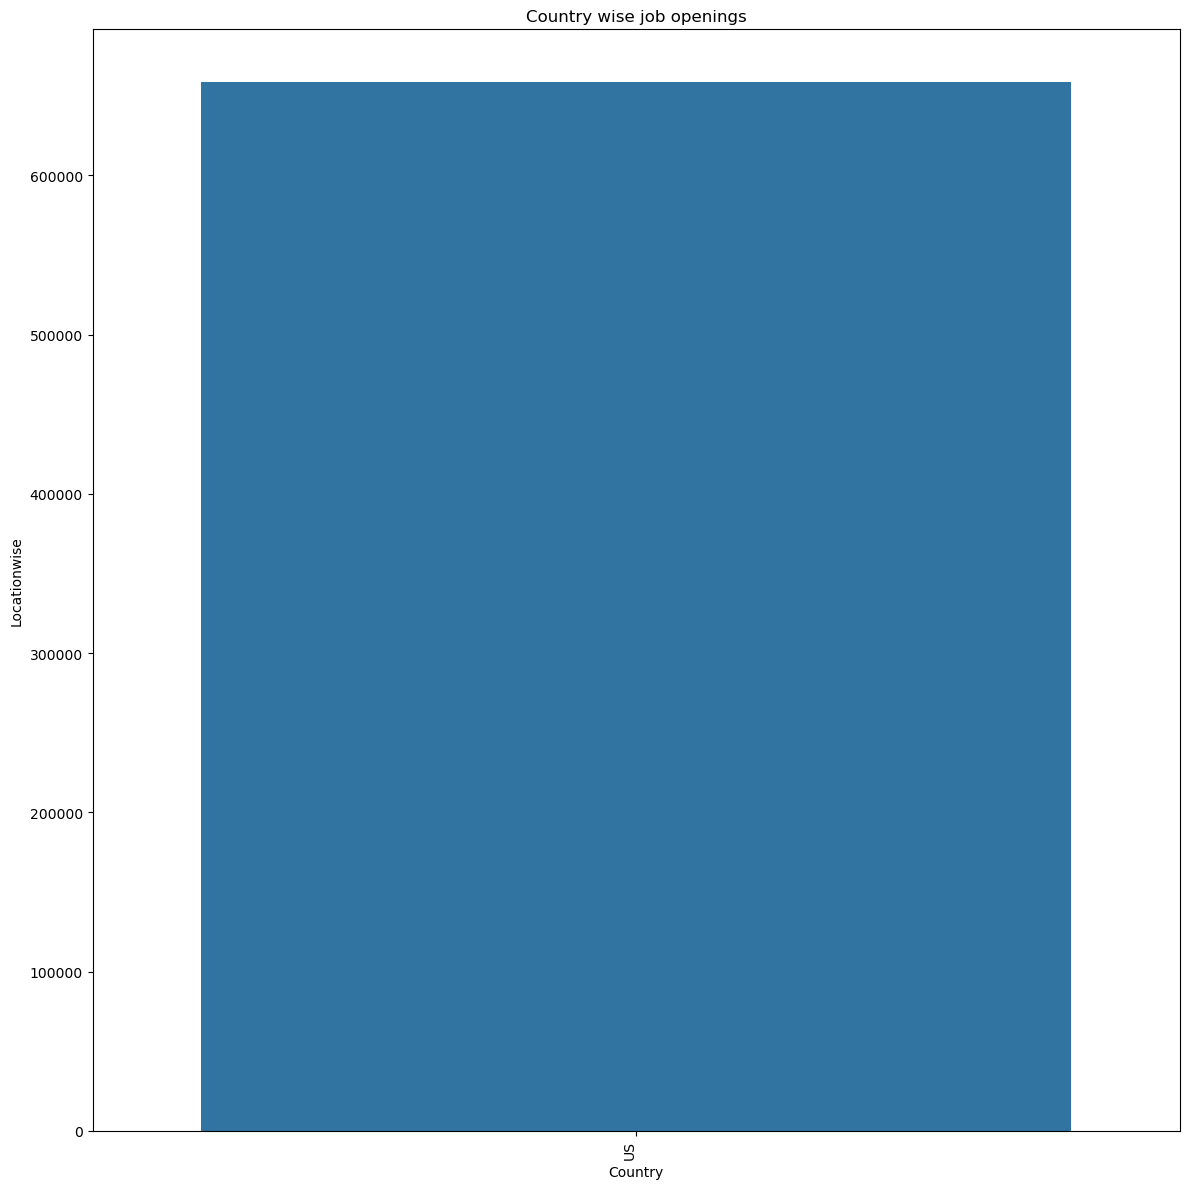

In [130]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="Country", y="Locationwise", data=Country_wise_job)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Country wise job openings')
plt.tight_layout()
plt.show()

### pre-processing

* Now we will perform following pre-processing steps:
  * We will consider only US region for building this recommendation engine
  * We will be removing data records where state is blank or state data attribute is having numerical value.(If needed)

In [131]:
jobs_US = jobs.loc[jobs['Country']=='US']

In [132]:
jobs_US[['City','State','Country']]

City State Country
0          Washington    DC      US
1           Charlotte    NC      US
2         Winter Park    FL      US
5        Ormond Beach    FL      US
6             Orlando    FL      US
...               ...   ...     ...
1091916       Chicago    IL      US
1091917    Schaumburg    IL      US
1091918     Amsterdam    NY      US
1091920      Carthage    MS      US
1091921        Warren    MI      US

[658835 rows x 3 columns]

In [133]:
jobs_US.groupby(['City','State','Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False).head()

City State Country  Locationwise
5782   Houston    TX      US         12180
8620  New York    NY      US         10810
2327   Chicago    IL      US         10741
3050    Dallas    TX      US          7444
9606   Phoenix    AZ      US          6765

In [134]:
State_wise_job_US = jobs_US.groupby(['State']).size().reset_index(name=
                                                                       'Locationwise'
                                                                      ).sort_values('Locationwise',ascending=False)

In [135]:
State_wise_job_US

State  Locationwise
5     CA         66871
47    TX         56912
10    FL         42828
16    IL         37197
37    NY         32172
41    PA         30896
38    OH         29074
34    NJ         23224
30    NC         20528
49    VA         19081
11    GA         19003
22    MD         18946
24    MI         18045
4     AZ         16769
17    IN         16404
21    MA         15679
25    MN         14630
52    WA         14137
53    WI         14013
46    TN         13614
6     CO         13286
26    MO         11588
7     CT         10616
19    KY         10415
44    SC          8088
18    KS          7721
14    IA          7342
1     AL          6897
40    OR          6592
20    LA          5928
39    OK          5834
36    NV          4544
48    UT          4367
8     DC          3953
35    NM          3279
28    MS          3164
9     DE          3029
32    NE          2803
2     AR          2745
33    NH          2225
15    ID          1857
31    ND          1777
54    WV          1701
13    HI          1632
43    RI          1489
45    SD          1240
51    VT          1207
23    ME          1086
29    MT           785
0     AK           682
55    WY           627
42    PR           271
12    GU            23
50    VI            16
3     AS             2
27    MP             1

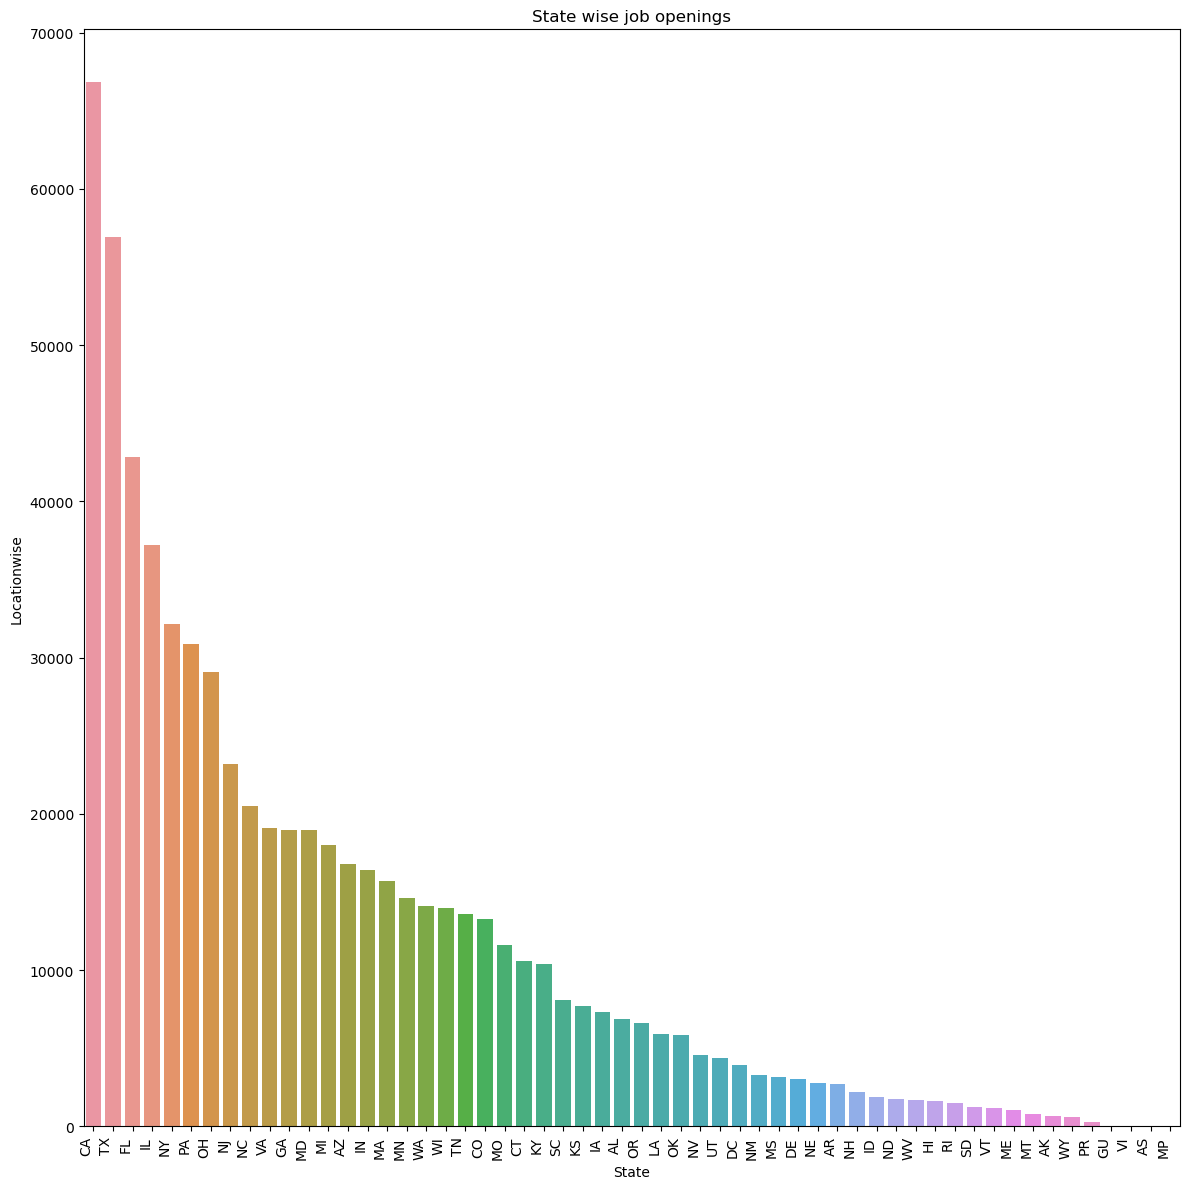

In [136]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="State", y="Locationwise",data=State_wise_job_US)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job openings')
plt.tight_layout()
plt.show()

In [137]:
jobs_US.groupby(['City']).size().reset_index(name='Locationwise').sort_values('Locationwise',ascending=False)

City  Locationwise
4084       Houston         12190
6095      New York         10810
1602       Chicago         10741
2108        Dallas          7482
6846       Phoenix          6767
...            ...           ...
8008       Silsbee             1
8009    Silver Bay             1
3718      Harbeson             1
8011  Silver Creek             1
0         29 Palms             1

[9701 rows x 2 columns]

In [138]:
City_wise_location = jobs_US.groupby(['City']).size().reset_index(
    name='Locationwise').sort_values('Locationwise',ascending=False)

In [139]:
City_wise_location_th = City_wise_location.loc[City_wise_location['Locationwise']>=12]

In [140]:
City_wise_location_th

City  Locationwise
4084       Houston         12190
6095      New York         10810
1602       Chicago         10741
2108        Dallas          7482
6846       Phoenix          6767
...            ...           ...
6641         Pampa            12
5531  Miami Shores            12
9181       Weirton            12
9134       Waupaca            12
6658      Paradise            12

[3672 rows x 2 columns]

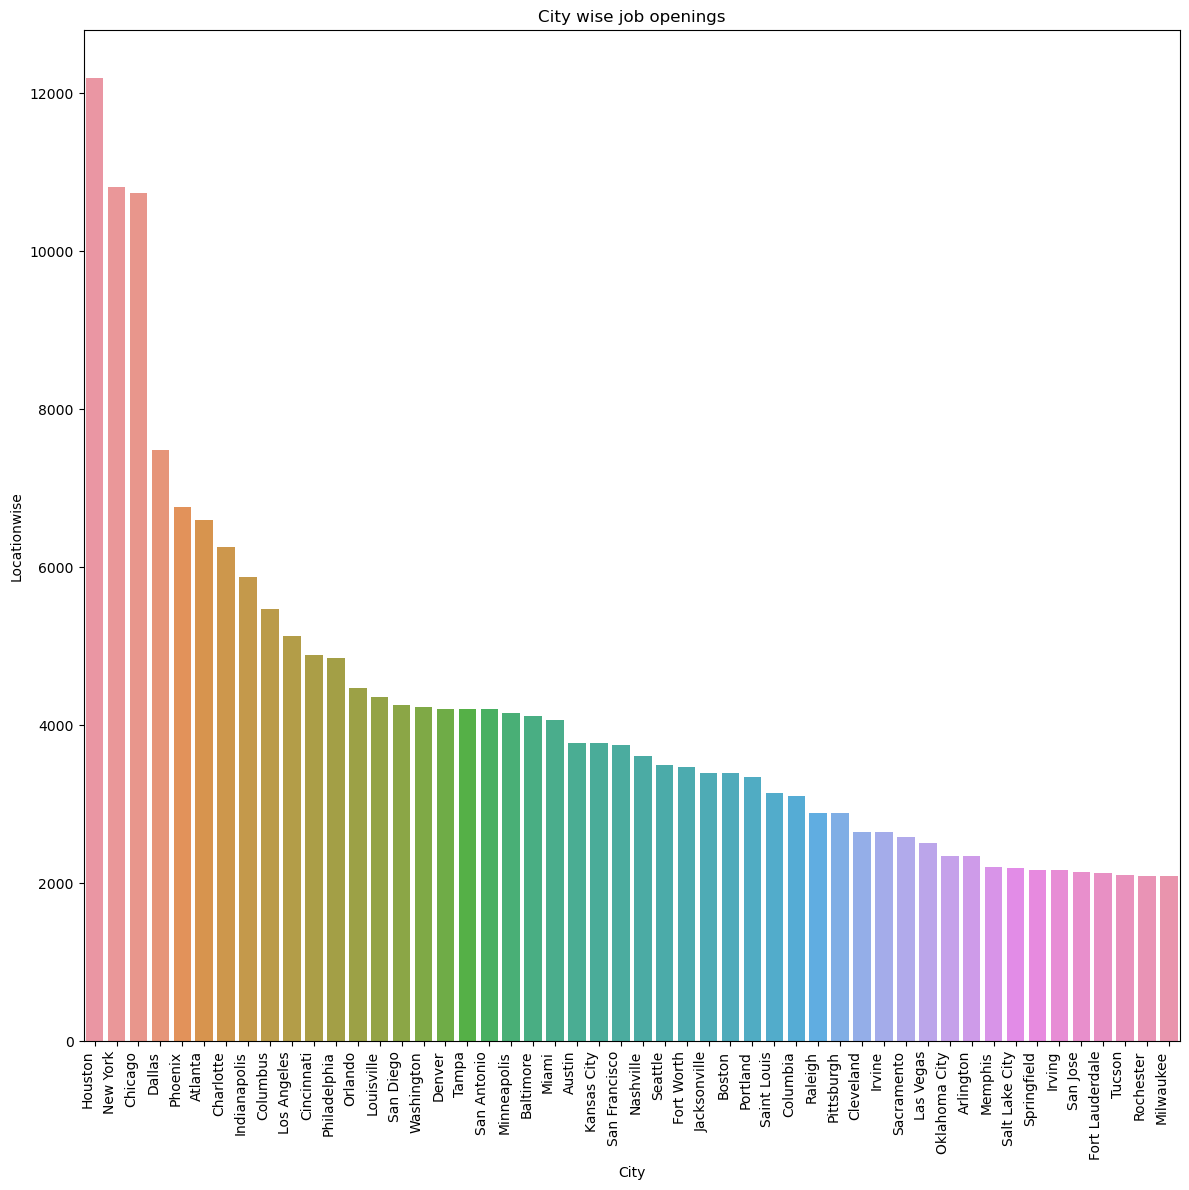

In [141]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="City", y="Locationwise",data=City_wise_location_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('City wise job openings')
plt.tight_layout()
plt.show()

#### Insights:

* When we do analysis state-wise then CA, TX, FL, IL and NY are having more job opening then other state
* When we do analysis city-wise then Houston, New York, Chicago, Dallas, Atlanta and Phoenix are having more jobs     compare to other cities

We have analyze the demand (job openings). Now there is time to analyze the supply(user-profiles)

### EDA for User profiles based on their location information

In [142]:
users_training.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                                        ascending=False).head()

Country  Locationwise
3      US        189793
2      MX             2
0      CA             1
1      IT             1

In [143]:
user_training_US = users_training.loc[users_training['Country']=='US']

In [144]:
user_training_US.shape

(189793, 15)

In [145]:
user_training_US.groupby(['State']).size().reset_index(
    name='Locationwise_state').sort_values('Locationwise_state',ascending=False)

State  Locationwise_state
11    FL               20093
47    TX               16482
6     CA               15316
17    IL               11879
37    NY               10326
41    PA                8966
34    NJ                7922
12    GA                7834
38    OH                7681
30    NC                7502
18    IN                7021
23    MD                5868
25    MI                5694
5     AZ                5387
49    VA                4597
44    SC                4263
46    TN                4258
27    MO                3674
20    KY                3449
8     CT                3332
19    KS                2315
53    WI                2269
21    LA                2238
22    MA                2217
2     AL                2204
7     CO                2121
26    MN                1816
52    WA                1690
28    MS                1570
36    NV                1454
10    DE                1301
15    IA                1197
39    OK                 722
4     AR                 592
40    OR                 575
9     DC                 566
48    UT                 532
35    NM                 473
43    RI                 362
54    WV                 319
32    NE                 309
16    ID                 303
33    NH                 297
14    HI                 191
45    SD                 162
51    VT                 108
1     AK                  99
24    ME                  73
42    PR                  72
55    WY                  31
31    ND                  31
29    MT                  30
50    VI                   3
0     AE                   3
13    GU                   2
3     AP                   2

In [148]:
user_training_US_state_wise = user_training_US.groupby(['State']).size().reset_index(
    name='Locationwise_state').sort_values('Locationwise_state',ascending=False)

In [149]:
user_training_US_th = user_training_US_state_wise.loc[user_training_US_state_wise['Locationwise_state']>=12]

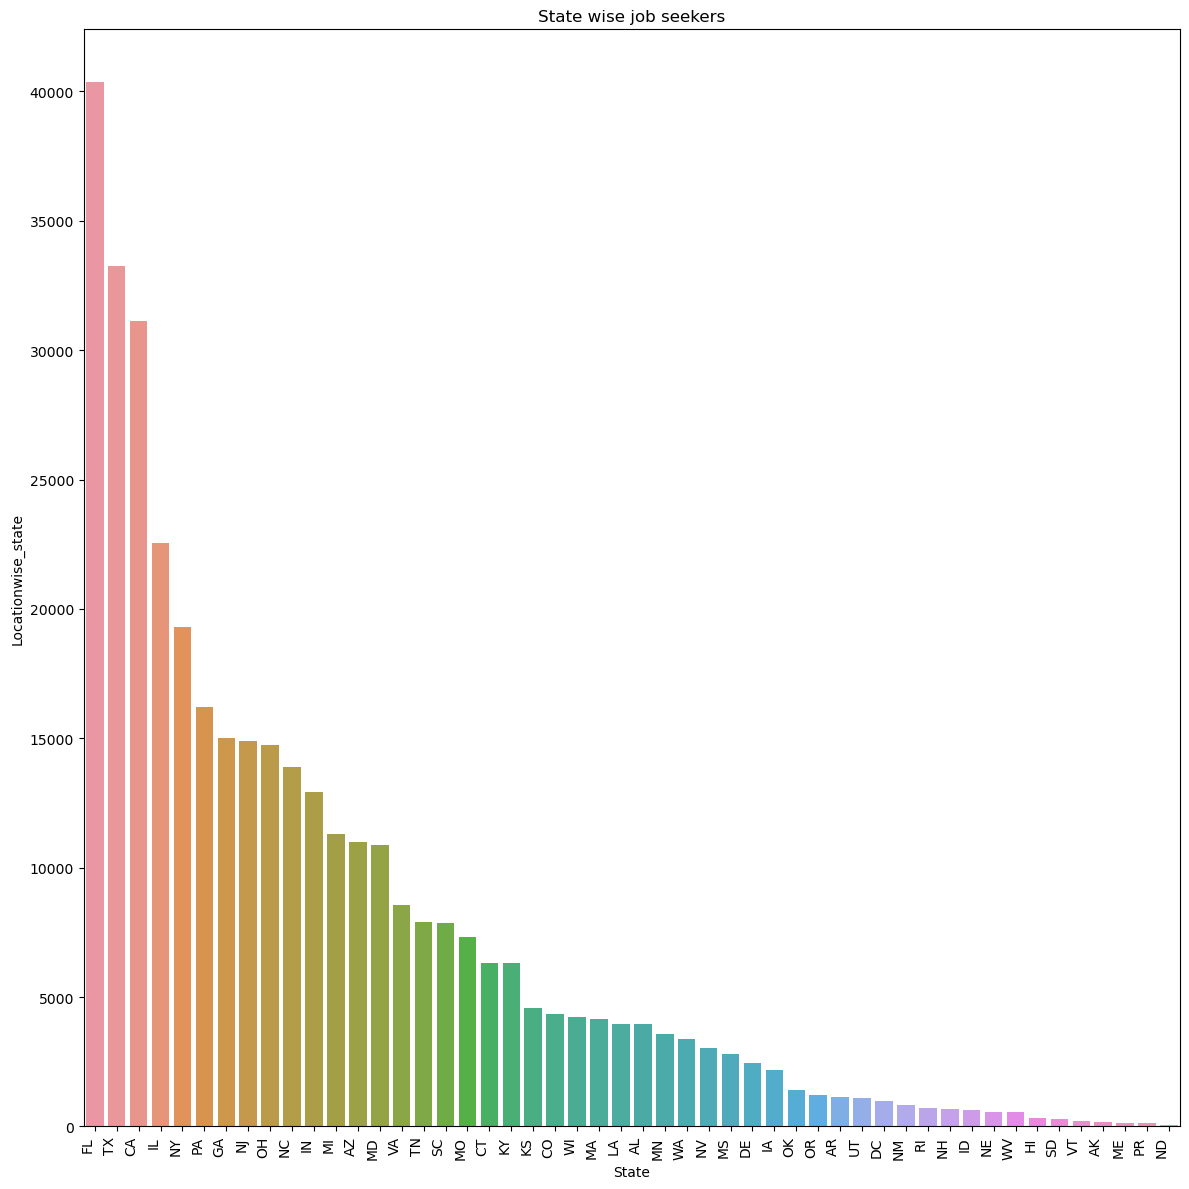

In [150]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="State", y="Locationwise_state",data=user_training_US_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()

In [146]:
user_training_US.groupby(['City']).size().reset_index(
    name='Locationwise_city').sort_values('Locationwise_city',ascending=False)

City  Locationwise_city
1273            Chicago               3852
3403            Houston               2842
5854       Philadelphia               2515
3498       Indianapolis               2393
4697              Miami               2300
...                 ...                ...
6667  San Juan Bautista                  1
3197             Hegins                  1
6670           San Leon                  1
6672           San Luis                  1
8429           san jose                  1

[8430 rows x 2 columns]

In [147]:
user_training_US_city_wise = user_training_US.groupby(['City']).size().reset_index(
    name='Locationwise_city').sort_values('Locationwise_city',ascending=False)

In [148]:
user_training_US_City_th = user_training_US_city_wise.loc[user_training_US_city_wise['Locationwise_city']>=12]

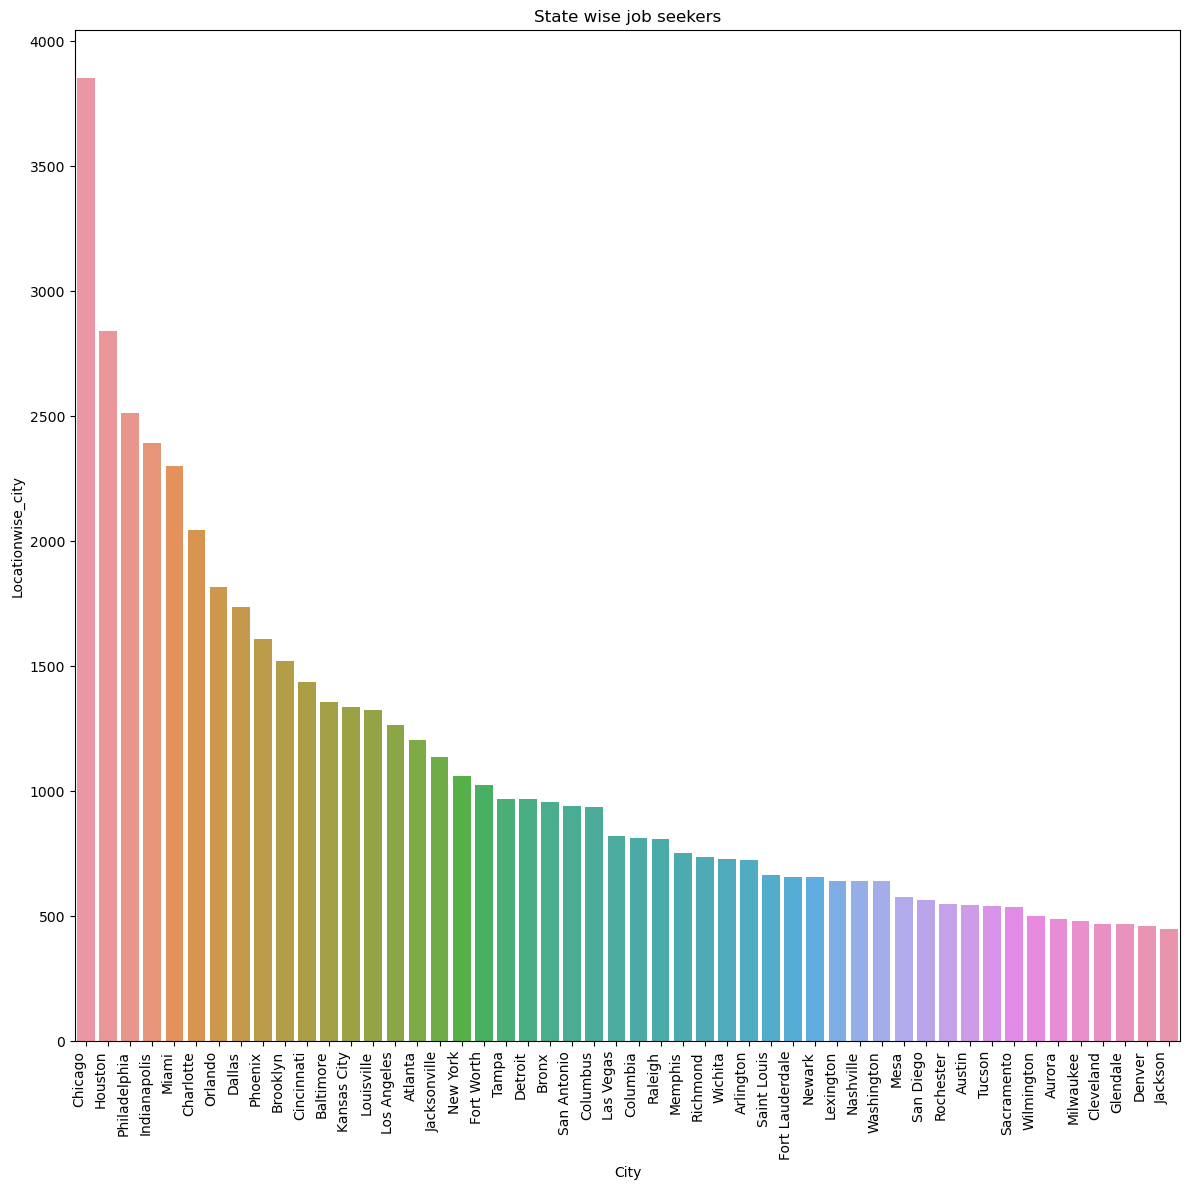

In [149]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="City", y="Locationwise_city",data=user_training_US_City_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()

* Here note that we are going to consider the US region for our further analysis. We are not removing any 
  data records right now.

* Up-till now we have obtain the popular state and city for job seeker and job creator

## revised approach


###  Let's find out Similar jobs

In [150]:
jobs_US.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')

In [151]:
jobs_US.head().transpose()

0  \
JobID                                                         1   
WindowID                                                      1   
Title                          Security Engineer/Technical Lead   
Description   <p>Security Clearance Required:&nbsp; Top Secr...   
Requirements  <p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...   
City                                                 Washington   
State                                                        DC   
Country                                                      US   
Zip5                                                      20531   
StartDate                               2012-03-07 13:17:01.643   
EndDate                                     2012-04-06 23:59:59   

                                                              1  \
JobID                                                         4   
WindowID                                                      1   
Title                                 SAP Business Analyst / WM   
Description   <strong>NO Corp. to Corp resumes&nbsp;are bein...   
Requirements  <p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...   
City                                                  Charlotte   
State                                                        NC   
Country                                                      US   
Zip5                                                      28217   
StartDate                               2012-03-21 02:03:44.137   
EndDate                                     2012-04-20 23:59:59   

                                                              2  \
JobID                                                         7   
WindowID                                                      1   
Title                             P/T HUMAN RESOURCES ASSISTANT   
Description   <b>    <b> P/T HUMAN RESOURCES ASSISTANT</b> <...   
Requirements  Please refer to the Job Description to view th...   
City                                                Winter Park   
State                                                        FL   
Country                                                      US   
Zip5                                                      32792   
StartDate                               2012-03-02 16:36:55.447   
EndDate                                     2012-04-01 23:59:59   

                                                              5  \
JobID                                                        10   
WindowID                                                      1   
Title                                     SALON/SPA COORDINATOR   
Description   <b>    <b>— SALON/SPA COORDINATOR             ...   
Requirements  Please refer to the Job Description to view th...   
City                                               Ormond Beach   
State                                                        FL   
Country                                                      US   
Zip5                                                      32174   
StartDate                               2012-03-05 14:21:50.203   
EndDate                                     2012-04-04 23:59:59   

                                                              6  
JobID                                                        11  
WindowID                                                      1  
Title                                            SUPERINTENDENT  
Description   <b>    <b>SUPERINTENDENT</b> </b>  ——  Central...  
Requirements  Please refer to the Job Description to view th...  
City                                                    Orlando  
State                                                        FL  
Country                                                      US  
Zip5                                                      32801  
StartDate                                2012-03-06 09:21:54.58  
EndDate                                     2012-04-05 23:59:59

In [152]:
jobs_US_base_line = jobs_US.iloc[0:10000,0:8]

In [153]:
jobs_US_base_line.head()

JobID  WindowID                             Title  \
0      1         1  Security Engineer/Technical Lead   
1      4         1         SAP Business Analyst / WM   
2      7         1     P/T HUMAN RESOURCES ASSISTANT   
5     10         1             SALON/SPA COORDINATOR   
6     11         1                    SUPERINTENDENT   

                                         Description  \
0  <p>Security Clearance Required:&nbsp; Top Secr...   
1  <strong>NO Corp. to Corp resumes&nbsp;are bein...   
2  <b>    <b> P/T HUMAN RESOURCES ASSISTANT</b> <...   
5  <b>    <b>— SALON/SPA COORDINATOR             ...   
6  <b>    <b>SUPERINTENDENT</b> </b>  ——  Central...   

                                        Requirements          City State  \
0  <p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...    Washington    DC   
1  <p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...     Charlotte    NC   
2  Please refer to the Job Description to view th...   Winter Park    FL   
5  Please refer to the Job Description to view th...  Ormond Beach    FL   
6  Please refer to the Job Description to view th...       Orlando    FL   

  Country  
0      US  
1      US  
2      US  
5      US  
6      US

In [154]:
jobs_US_base_line['Title'] = jobs_US_base_line['Title'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Description'].fillna('')
#jobs_US_base_line['Requirements'] = jobs_US_base_line['Requirements'].fillna('')

jobs_US_base_line['Description'] = jobs_US_base_line['Title'] + jobs_US_base_line['Description']

In [155]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(jobs_US_base_line['Description'])

In [156]:
tfidf_matrix.shape

(10000, 548987)

In [166]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import linear_kernel

In [167]:
# Create a KNN model
k = 5  # Choose the number of neighbors (k)
knn_model = NearestNeighbors(n_neighbors=k, metric='cosine')
knn_model.fit(tfidf_matrix)


NearestNeighbors(metric='cosine')

In [179]:
# Load your data (replace 'your_dataset.csv' with your actual file path)

# Preprocess your data
jobs_US_base_line = jobs_US.iloc[0:10000, 0:8]
jobs_US_base_line['Title'] = jobs_US_base_line['Title'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Description'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Title'] + ' ' + jobs_US_base_line['Description']

# Create TF-IDF vectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(jobs_US_base_line['Description'])

# Calculate cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Create a KNN model
k = 5  # Choose the number of neighbors (k)
knn_model = NearestNeighbors(n_neighbors=k, metric='cosine')
knn_model.fit(tfidf_matrix)

# Reset the index and create a Series of titles and their corresponding indices
jobs_US_base_line = jobs_US_base_line.reset_index()
titles = jobs_US_base_line['Title']
indices = pd.Series(jobs_US_base_line.index, index=jobs_US_base_line['Title'])

def get_knn_recommendations(title, knn_model, titles, tfidf_matrix):
    # Find the index of the given title
    idx = indices[title]

    # Reshape the TF-IDF matrix for the query point
    query_tfidf = tfidf_matrix[idx].reshape(1, -1)

    # Find k-nearest neighbors for the given job title
    distances, neighbor_indices = knn_model.kneighbors(query_tfidf)

    # Get the job titles of the k-nearest neighbors
    similar_job_titles = titles.iloc[neighbor_indices[0]].tolist()

    return similar_job_titles



In [183]:
# Example usage
title_to_search = 'SAP Business Analyst / WM'
recommendations = get_knn_recommendations(title_to_search, knn_model, titles, tfidf_matrix)

print("Top {} similar job titles to '{}':".format(k, title_to_search))
recommendations

Top 5 similar job titles to 'SAP Business Analyst / WM':


['SAP Business Analyst / WM',
 'SAP FI/CO Business Consultant',
 'SAP Business Systems Analyst',
 'SAP Basis Administrator - Direct hire position',
 'SAP Global BCS Finance Analyst']

In [182]:
# Assuming you have recommendations as a list of job titles
recommendations = get_knn_recommendations(title_to_search, knn_model, titles, tfidf_matrix)

# Display recommendations with additional information
recommended_jobs = jobs_US_base_line[jobs_US_base_line['Title'].isin(recommendations)]
recommended_jobs = recommended_jobs[['Title', 'Description', 'City', 'State', 'Country']]

# Print or display the recommended jobs with details
print("Top {} similar job titles to '{}':".format(k, title_to_search))
recommended_jobs

Top 5 similar job titles to 'SAP Business Analyst / WM':


Title  \
1                          SAP Business Analyst / WM   
3144                   SAP FI/CO Business Consultant   
7538                  SAP Global BCS Finance Analyst   
7802                    SAP Business Systems Analyst   
9050  SAP Basis Administrator - Direct hire position   

                                            Description          City State  \
1     SAP Business Analyst / WM <strong>NO Corp. to ...     Charlotte    NC   
3144  SAP FI/CO Business Consultant <DIV> The SAP Bu...        Dallas    TX   
7538  SAP Global BCS Finance Analyst <DIV> </DIV>\r<...  Bartlesville    OK   
7802  SAP Business Systems Analyst <p><span>Sorry - ...       Hanover    MD   
9050  SAP Basis Administrator - Direct hire position...        Dallas    TX   

     Country  
1         US  
3144      US  
7538      US  
7802      US  
9050      US

In [184]:
# Example usage
title_to_search = 'SAP Business Analyst / WM'
recommendations = get_knn_recommendations(title_to_search, knn_model, titles, tfidf_matrix)

print("Top {} similar job titles to '{}':".format(k, title_to_search))
recommendations

KeyError: 'SAP Business Analyst / WM'

In [191]:
# Assuming you have recommendations as a list of job titles
recommendations = get_knn_recommendations(title_to_search, knn_model, titles, tfidf_matrix)

# Display recommendations with additional information
recommended_jobs = jobs_US_base_line[jobs_US_base_line['Title'].isin(recommendations)]
recommended_jobs = recommended_jobs[['Title', 'Description', 'City', 'State', 'Country']]

# Print or display the recommended jobs with details
print("Top {} similar job titles to '{}':".format(k, title_to_search))
recommended_jobs

Top 5 similar job titles to 'Immediate Opening':


Title  \
11              Immediate Opening   
60                       Optician   
80    A/C HEATING REFRIG MECHANIC   
105                      Optician   
149         Accounting/Bookkeeper   
357                        DENTAL   
3682                     Optician   
6963        Accounting/Bookkeeper   

                                            Description        City State  \
11    Immediate Opening Immediate Opening - AR Clerk...     Orlando    FL   
60    Optician Optician BA18408 Bowers & Snyder - ex...   Baltimore    MD   
80    A/C HEATING REFRIG MECHANIC A/C Heating Refrig...  Nottingham    MD   
105   Optician Optician -  Optician (license not nec...      Weston    FL   
149   Accounting/Bookkeeper <p>Accounting/Bookkeeper...     Chicago    IL   
357   DENTAL DENTIST - PT 2-3 days, 2yrs exp. Biling...     Fontana    CA   
3682  Optician <DIV>\r<P style="MARGIN: 0pt; TEXT-AL...     Houston    TX   
6963  Accounting/Bookkeeper Growing and busy company...  Farmington    MI   

     Country  
11        US  
60        US  
80        US  
105       US  
149       US  
357       US  
3682      US  
6963      US

In [171]:
# # http://scikit-learn.org/stable/modules/metrics.html#linear-kernel
# cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [172]:
# cosine_sim[0]

In [173]:
# jobs_US_base_line = jobs_US_base_line.reset_index()
# titles = jobs_US_base_line['Title']
# indices = pd.Series(jobs_US_base_line.index, index=jobs_US_base_line['Title'])
# #indices.head(2)


In [174]:
# def get_recommendations(title):
#     idx = indices[title]
#     #print (idx)
#     sim_scores = list(enumerate(cosine_sim[idx]))
#     #print (sim_scores)
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     job_indices = [i[0] for i in sim_scores]
#     return titles.iloc[job_indices]

In [175]:
# get_recommendations('SAP Business Analyst / WM').head(10)

In [176]:
# get_recommendations('Security Engineer/Technical Lead').head(10)

In [177]:
# get_recommendations('Immediate Opening').head(10)

In [178]:
# get_recommendations('EXPERIENCED ROOFERS').head(10)

## Best approach

#### Find out similar users -- Find out for which jobs they have applied -- suggest those job to the other users who shared similar user profile.

We are finding put similar user profile based on their degree type, majors and total years of experience. 
* We will get to 10 similar users.
* We will find our which are the jobs for which these users have applied
* We take an union of these jobs and recommend the jobs all these user base

In [193]:
users_training.head()

UserID  WindowID  Split          City State Country ZipCode   DegreeType  \
1      72         1  Train       La Mesa    CA      US   91941     Master's   
2      80         1  Train  Williamstown    NJ      US   08094  High School   
3      98         1  Train       Astoria    NY      US   11105     Master's   
4     123         1  Train   Baton Rouge    LA      US   70808   Bachelor's   
6     162         1  Train    Long Beach    CA      US   90807     Master's   

                   Major       GraduationDate  WorkHistoryCount  \
1           Anthropology  2011-01-01 00:00:00                10   
2         Not Applicable  1985-06-01 00:00:00                 5   
3             Journalism  2007-05-01 00:00:00                 3   
4  Agricultural Business  2011-05-01 00:00:00                 1   
6         I/O Psychology  2012-05-01 00:00:00                10   

   TotalYearsExperience CurrentlyEmployed ManagedOthers  ManagedHowMany  
1                   8.0               Yes            No               0  
2                  11.0               Yes           Yes               5  
3                   3.0               Yes            No               0  
4                   9.0               Yes            No               0  
6                  25.0                No            No               0

In [194]:
user_based_approach_US = users_training.loc[users_training['Country']=='US']

In [195]:
user_based_approach = user_based_approach_US.iloc[0:10000,:]

In [196]:
user_based_approach.head()

UserID  WindowID  Split          City State Country ZipCode   DegreeType  \
1      72         1  Train       La Mesa    CA      US   91941     Master's   
2      80         1  Train  Williamstown    NJ      US   08094  High School   
3      98         1  Train       Astoria    NY      US   11105     Master's   
4     123         1  Train   Baton Rouge    LA      US   70808   Bachelor's   
6     162         1  Train    Long Beach    CA      US   90807     Master's   

                   Major       GraduationDate  WorkHistoryCount  \
1           Anthropology  2011-01-01 00:00:00                10   
2         Not Applicable  1985-06-01 00:00:00                 5   
3             Journalism  2007-05-01 00:00:00                 3   
4  Agricultural Business  2011-05-01 00:00:00                 1   
6         I/O Psychology  2012-05-01 00:00:00                10   

   TotalYearsExperience CurrentlyEmployed ManagedOthers  ManagedHowMany  
1                   8.0               Yes            No               0  
2                  11.0               Yes           Yes               5  
3                   3.0               Yes            No               0  
4                   9.0               Yes            No               0  
6                  25.0                No            No               0

In [197]:
user_based_approach['DegreeType'] = user_based_approach['DegreeType'].fillna('')
user_based_approach['Major'] = user_based_approach['Major'].fillna('')
user_based_approach['TotalYearsExperience'] = str(user_based_approach['TotalYearsExperience'].fillna(''))

user_based_approach['DegreeType'] = user_based_approach['DegreeType'] + user_based_approach['Major'] +user_based_approach['TotalYearsExperience']
# user_based_approach['DegreeType'] = user_based_approach['DegreeType'].fillna('')
# user_based_approach['Major'] = user_based_approach['Major'].fillna('')
# user_based_approach['TotalYearsExperience'] = user_based_approach['TotalYearsExperience'].fillna('')

# user_based_approach['NewColumn'] = user_based_approach['DegreeType'] + ' ' + user_based_approach['Major'] + ' ' + user_based_approach['TotalYearsExperience']


In [198]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(user_based_approach['DegreeType'])

In [199]:
tfidf_matrix.shape

(10000, 8922)

In [200]:
# http://scikit-learn.org/stable/modules/metrics.html#linear-kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [201]:
cosine_sim[0]

array([1.        , 0.24397639, 0.18222102, ..., 0.18136024, 0.15582172,
       0.12424889])

In [202]:

user_based_approach = user_based_approach.reset_index()
userid = user_based_approach['UserID']
indices = pd.Series(user_based_approach.index, index=user_based_approach['UserID'])
#indices.head(2)

In [203]:
def get_recommendations_userwise(userid):
    idx = indices[userid]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    user_indices = [i[0] for i in sim_scores]
    #print (user_indices)
    return user_indices[0:11]

In [204]:
print ("-----Top 10 Similar users with userId: 123------")
get_recommendations_userwise(123)


-----Top 10 Similar users with userId: 123------


[3, 71, 593, 5116, 1226, 1432, 3801, 1126, 3745, 8603, 9427]

In [205]:
def get_job_id(usrid_list):
    jobs_userwise = apps_training['UserID'].isin(usrid_list) #
    df1 = pd.DataFrame(data = apps_training[jobs_userwise], columns=['JobID'])
    joblist = df1['JobID'].tolist()
    Job_list = jobs['JobID'].isin(joblist) #[1083186, 516837, 507614, 754917, 686406, 1058896, 335132])
    df_temp = pd.DataFrame(data = jobs[Job_list], columns=['JobID','Title','Description','City','State'])
    return df_temp

In [206]:
get_job_id(get_recommendations_userwise(123))

JobID                                              Title  \
15538    59591                    Warehouse 1 Shipping- 3rd Shift   
223914  878116         STNA / RN / LPN / Cook / Server / Security   
230547  902826  Macy's St. Charles Town Center, Waldorf, MD: L...   
605596  205113  ADMINISTRATIVE ASSISTANT - PART TIME, 25 HRS/WEEK   
690061  877773                Medical Office Front Desk Assistant   

                                              Description  \
15538   ESSENTIAL FUNCTION:\r\nThe basic function of t...   
223914  <DIV>\r<P><SPAN></SPAN></P>\r<P style="TEXT-AL...   
230547  <BR> <B>Overview:</B><BR>  <BR> As a Macy's Lo...   
605596  <br />\rSumitomo Electric Carbide, Inc., a wor...   
690061  We are looking for a front desk employee at a ...   

                        City State  
15538             Brandywine    MD  
223914            Cincinnati    OH  
230547               Waldorf    MD  
605596        Mount Prospect    IL  
690061  Lutherville Timonium    MD

In [209]:
# def get_recommendations_userwise(userid):
#     idx = indices[userid]
#     sim_scores = list(enumerate(cosine_sim[idx]))
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     user_indices = [i[0] for i in sim_scores]
#     return user_indices

# def hybrid_recommendations(userid):
#     user_indices = get_recommendations_userwise(userid)
#     recommended_jobs_user_based = get_job_id(user_indices)['Title'].tolist()
#     recommended_jobs_job_based = get_recommendations(recommended_jobs_user_based[0]).tolist()
#     return recommended_jobs_job_based





In [219]:
def get_knn_recommendations(title, knn_model, titles, tfidf_matrix):
    # Check if the given title exists in the titles index
    if title not in titles.index:
        return []  # Return an empty list if the title is not found
    
    # Find the index of the given title
    idx = titles.index.get_loc(title)

    # Reshape the TF-IDF matrix for the query point
    query_tfidf = tfidf_matrix[idx].reshape(1, -1)

    # Find k-nearest neighbors for the given job title
    distances, neighbor_indices = knn_model.kneighbors(query_tfidf)

    # Get the job titles of the k-nearest neighbors
    similar_job_titles = titles.iloc[neighbor_indices[0]].tolist()

    return similar_job_titles


To create a hybrid recommendation model that combines the two methods (content-based and user-based), you can follow these steps:

    Content-Based Filtering:
        You've already implemented the content-based recommendation system based on job titles and descriptions using TF-IDF and KNN. You can use this as one component of your hybrid model.

    User-Based Filtering:
        You've also implemented the user-based recommendation system based on user profiles using TF-IDF and cosine similarity. This is the second component of your hybrid model.

    Combine Recommendations:
        Retrieve recommendations from both the content-based and user-based models for a given user.
        You can weigh the recommendations differently if needed, giving one model's recommendations more importance over the other.

    Display Recommendations:
        Display the combined recommendations to the user.

In [222]:
# Combine Recommendations
user_id = 123  # Replace with the user ID for whom you want to make recommendations
# Get content-based recommendations
content_based_recommendations = get_knn_recommendations(title_to_search, knn_model, titles, tfidf_matrix)

# Get user-based recommendations
user_based_recommendations_indices = get_recommendations_userwise(user_id)
user_based_recommendations = jobs_US_base_line.loc[user_based_recommendations_indices, 'Title'].tolist()

# You can weigh and merge the recommendations from both models as per your preference

# Display Combined Recommendations
combined_recommendations = list(set(content_based_recommendations + user_based_recommendations))
print("Combined Recommendations for UserID {}: ".format(user_id))
combined_recommendations


Combined Recommendations for UserID 123: 


['Manual Machine Operator',
 'OPENING : SALES / MARKETING ASSOCIATES NEEDED IMMEDIATELY*****',
 'Network Engineer',
 'Sr Finance Manager - Profitability Analysis',
 'Consultant',
 'Project Coordinator (New Rochelle, NY)',
 'Strategic Sourcing Manager',
 'Control / Data Network Engineer Communications',
 'Financial Service Associate 10731 Oberlin OH',
 'A/P Accounting Assistant',
 'Validation Associate',
 'Technical Support / Customer Service (Direct-Hire + Benefits)',
 'Value Stream Leader',
 'Sr.Project Manager/Estimator',
 'IT Operations Shift Manager (Tier II) (Wednesday-Saturday) (2PM',
 'Store Manager - Muscle Shoals, AL',
 'Licensed Fire Protection Engineer',
 'Health Coach',
 'UI developer / User Interface',
 'Qualified Medical Aide -- QMA',
 'Assistant Professor Soil Biophysics/Soil Management',
 'Shipping/Receiving',
 'Smog Technician',
 'ZARA HIRING  AT OUR AVENTURAL MALL LOCATION',
 'Financial Advisor Trainee - New Orleans and Surrounding Areas',
 'Pharmacy Clerk',
 'Payroll

In [224]:
# Sort recommendations from each model separately by relevance score
sorted_content_based = sorted(content_based_recommendations, key=lambda x: relevance_score(x))
sorted_user_based = sorted(user_based_recommendations, key=lambda x: relevance_score(x))

# Combine rankings (e.g., weighted average)
combined_ranking = (
    (weight_content_based * sorted_content_based) +
    (weight_user_based * sorted_user_based)
)

# Present final recommendations based on the combined ranking
combined_recommendations = get_top_n_recommendations(combined_ranking, n)


NameError: name 'relevance_score' is not defined